<a href="https://colab.research.google.com/github/eflatlan/CNN_PID/blob/dev_floatmap/Dense_radius_notCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install h5py numpy

import os
import h5py
import numpy as np

from google.colab import drive
drive.mount('/content/drive')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [3]:
#!wget https://raw.githubusercontent.com/eflatlan/CNN_PID/dev_floatmap/helper_functions.py
#from helper_functions.py import print_points, plot_mapsm

In [ ]:

def calc_dist2mip(maps = None,  mip_positions = None, resolution = 10):
#        X_dist2mip = calc_dist2mip(maps = X_map, mip_positions = X_mip_position, resolution = resolution)

    length = maps.shape[0]
    distances_map_list = []



    #i = 0
    for i in range (length):

        map = np.array(maps[i, :,:])
        mip_pos = np.array(mip_positions[i, :])

        #print(f"filled_bins shape = {filled_bins.shape}")
        #print(f"map shape = {map.shape}")
        #print(f"mip_pos shape = {mip_pos.shape}")

        _mip_position = []

        distances_map = []
        for y in range(map.shape[0]):
            for x in range(map.shape[1]):
                if map[y, x] == 1:
                    point = (x, y)
                    distance = np.linalg.norm(np.array(point) - mip_pos*resolution)
                    if distance < 80*resolution: # dont add if distance is unreasonably large
                      distances_map.append(distance)
        
        
        
        distances_map_list.append(distances_map)


    # TODO: NB this should be removed, if i dont add it distances_map_list is one elem shorter than the other dataframes
    temp = [27.99869560103273, 27.39768312402287, 28.127088937838945, 28.508241484815493, 28.39480852480028, 27.750048098528, 27.76846907102987, 28.321466287495472, 28.533328982612467, 27.281300043587986, 27.089013468042527, 27.830518584558593, 27.96534572138025, 27.921429872604552, 27.22372568233926]  
      
    #distances_map_list.append(temp)


    print(f"maps shape = {maps.shape}")
    print(f"mip_position_array shape = {mip_positions.shape}")
    print(f"distances_map_list shape = {np.array(distances_map_list, dtype=object).shape}")

    return distances_map_list

In [5]:
import math

class Constants:
    def __init__(self):
        self.defaultPhotonEnergy = 6.75
        self.CH4GapWidth = 8.0
        self.RadiatorWidth = 1.0
        self.QuartzWindowWidth = 0.5
        self.EmissionLength = self.RadiatorWidth / 2.0

class Masses:
    def __init__(self):
        self.mass_Pion = 0.1396
        self.mass_Kaon = 0.4937
        self.mass_Proton = 0.938


# Create constants and masses objects outside of CkovCalculator
constants = Constants()
masses = Masses()

class CkovCalculator:
    #def __init__(self):
        #self.constants = constants
        #self.masses = masses
    def GetFreonIndexOfRefraction(self, photonEnergy):
        x = photonEnergy
        k = 1.177 + (0.0172) * x
        return k

    def GetQuartzIndexOfRefraction(self, x):
        k = math.sqrt(1 + 46.411 / (113.763556 - x) + 228.71 / (328.51563 - x))
        return k

    def getRadiusFromCkov(self, ckovAngle):
        refIndexFreon = self.GetFreonIndexOfRefraction(constants.defaultPhotonEnergy)
        refIndexQuartz = self.GetQuartzIndexOfRefraction(constants.defaultPhotonEnergy)
        refIndexCH4 = 1.0

        sin_ckov = math.sin(ckovAngle)
        sin_qz = sin_ckov * (refIndexFreon / refIndexQuartz)
        sin_theta0 = sin_qz * (refIndexQuartz / refIndexCH4)

        R_ckov = sin_ckov * (constants.RadiatorWidth - constants.EmissionLength)
        R_qz = sin_qz * constants.QuartzWindowWidth
        R_0 = sin_theta0 * constants.CH4GapWidth

        R = R_ckov + R_qz + R_0
        return R

    def calcCkovFromMass(self, p, n):
        p_sq = p * p
        cos_ckov_denom = p * n

        radiuses = {}

        for particle, mass in masses.__dict__.items():
            # Skip non-mass attributes
            if not particle.startswith("mass"):
                continue

            mass_value = getattr(masses, particle)

            # sanity check
            if p_sq + mass_value * mass_value < 0:
                radiuses[particle] = 0.0
                continue

            cos_ckov = math.sqrt(p_sq + mass_value * mass_value) / cos_ckov_denom

            # sanity check
            if cos_ckov > 1 or cos_ckov < -1:
                radiuses[particle] = 0.0
                continue

            ckovAngle = math.acos(cos_ckov)
            radius = self.getRadiusFromCkov(ckovAngle)
            radiuses[particle] = radius
            #print(f"{particle} mass_value = {mass_value} Radius: {radius} ckov = {ckovAngle} momentum = {p} refindex = {n}")

        return radiuses


# Usage within a loop
for i in range(10):
    calculator = CkovCalculator()
    momentum = 1.5
    refractive_index = 1.289
    results = calculator.calcCkovFromMass(momentum, refractive_index)
    
    radiuses = results

    radiuses = []

    for particle, radius in results.items():
        #print(f"{particle} Radius: {radius}")
        radiuses.append(radius)

        

In [6]:
#@title Default title text
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
import os
import h5py
import tensorflow as tf

# to check the impact of resolution in the 2d-map; 
# print the difference between the filledBins vector versus the map (map is restricted by resolution)
def print_points(filled_bins_array = None, map_array = None, mip_position_array = None, resolution = 10):

    length = map_array.shape[0]
    distances_bins_list = []
    distances_map_list = []

    print(f"filled_bins_array shape = {filled_bins_array.shape}")
    print(f"map_array shape = {map_array.shape}")
    print(f"mip_position_array shape = {mip_position_array.shape}")


    for i in range (1, length):

        filled_bins = np.array(filled_bins_array[i])
        map = np.array(map_array[i, :,:])
        mip_pos = np.array(mip_position_array[i, :])

        #print(f"filled_bins shape = {filled_bins.shape}")
        #print(f"map shape = {map.shape}")
        #print(f"mip_pos shape = {mip_pos.shape}")

        _mip_position = []
        #_mip_position.append(mip_position_array[])
        distances2 = []

        distances_bins = [norm(np.array(pos) - mip_pos) for pos in filled_bins]

        distances_map = []
        for y in range(map.shape[0]):
            for x in range(map.shape[1]):
                if map[y, x] == 1:
                    point = (x, y)
                    distance = np.linalg.norm(np.array(point) - mip_pos*resolution)
                    distances_map.append(distance)
        
        
        
        distances_bins_list.append(distances_bins)
        distances_map_list.append(distances_map)


    # Print the distances for each element in map_data_list
    print(f"Element {i+1} distances:")
    for j, (distances_bins, distances_map) in enumerate(zip(distances_bins_list, distances_map_list)):
        print(f"  Point {j+1}: Distance bins: {distances_bins}\n, Distance map: {distances_map}")
    print()




def plot_maps(filled_bins_array=None, map_array=None, mip_position_array=None, X_momentum=None, X_refractive_index=None, X_ckov=None, percentage_to_plot=5, resolution = 10):
  """
  Args : filled_bins_array : array that holds the vectors of filled pads 
         map_array : 2d  map with a determined resolution (the points in the filled_bins_array element, just restricted by the resolution)
         mip_position_array : array of the MIP {x, y} positions

         TODO : add mass_category and actual mass?
  """
  

  #percentage_to_plot = 0.05 / 10

  # Calculate the starting index of the samples to plot
  num_samples = map_array.shape[0]
  start_index = -num_samples

  # Create a subplot with the number of rows based on the number of samples
  fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))

  # Iterate over the samples and plot each map with information
  for i, ax in enumerate(axes):
      # Get the map and corresponding information
      map_data = map_array[start_index + i, :, :]
      #mass_category = particle_vector[start_index + i].mass_category
      ckov = X_ckov[start_index + i]
      mip_position = mip_position_array[start_index + i]
      momentum = X_momentum[start_index + i]
      refractive_index = X_refractive_index[start_index + i]

      # Plot the map
      ax.imshow(map_data, cmap='gray')

      # Add a red dot at the MIP position
      ax.plot(mip_position[0]*resolution, mip_position[1]*resolution, 'ro')

      # Set the title with the information
      #ax.set_title(f"Mass: {mass_category}, CKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum},  refractive_index: {refractive_index}")
      ax.set_title(f"CKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum},  refractive_index: {refractive_index}")

      ax.axis('off')

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()

In [7]:
import matplotlib.pyplot as plt
import random

def plot_random_element(X_train_map):
    index = random.randint(0, len(X_train_map) - 1)  # Pick a random index
    element = X_train_map[index, :, :, 0]  # Retrieve the element

    plt.figure(figsize=(8, 6))
    plt.imshow(element, cmap='viridis', origin='lower')
    plt.title(f"Random Element from X_train_map (Index {index})")
    plt.colorbar(label='Intensity')
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.show()


    



In [8]:
def plot5(X_test_map, particle_vector):

  # Plotting random maps with information

  # Select 5 random indices from the test data
  random_indices = np.random.choice(range(X_test_map.shape[0]), size=5, replace=False)

  # Create a subplot with 5 rows and 1 column
  fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))

  # Iterate over the random indices and plot each map with information
  for i, index in enumerate(random_indices):
      # Get the map and corresponding information
      map_data = X_test_map[index, :, :, 0]
      mass_category = particle_vector[index].mass_category
      ckov = particle_vector[index].ckov
      mip_position = particle_vector[index].mip_position
      momentum = particle_vector[index].momentum
      
      # Plot the map
      axes[i].imshow(map_data, cmap='gray')
      
      # Add a red dot at the MIP position
      axes[i].plot(mip_position[0], mip_position[1], 'ro')
      
      # Set the title with the information    a
      #x.set_title(f"Mass: {mass_category}, CKOV: {ckov}, MIP Position: {mip_position:.4f}, Momentum: {momentum:.4f}")
      mip_pos = f"{mip_position:.4f}"
      axes[i].set_title(f"Mass: {mass_category}, CKOV: {ckov}, MIP Position: {mip_pos}, Momentum: {momentum}")
      axes[i].axis('off')

  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()

In [9]:
def create_lr_scheduler(num_epochs = 10):

  tf.random.set_seed(42)
  div = num_epochs/4
  print("div =", div)
  print("1e-4 * 10**(epoch/div) = ", 1e-4 * 10**(num_epochs/div))
  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/div)) # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch
  return lr_scheduler





def plot_lr(num_epochs = 10, history = None):
  div = num_epochs/4
  lrs = 1e-4 * (10 ** (np.arange(num_epochs)/div))
  plt.figure(figsize=(10, 7))
  plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
  plt.xlabel("Learning Rate")
  plt.ylabel("Loss")


  plt.title("Learning rate vs. loss");

In [10]:
#def plot_worst_(model, y_test, X_test_map, X_test_momentum, X_test_refractive_index, X_test_ckov, X_test_mip_position, y_pred):
def plot_worst_(model, y_test, X_test_map, X_test_momentum, X_test_refractive_index, X_test_ckov, X_test_mip_position, resolution):
  y_pred = model.predict([X_test_map, X_test_momentum, X_test_refractive_index, X_test_mip_position])
  print("Shape of y_pred: ", y_pred.shape)
  # 1. Predict labels on validation data
#plot_worst(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], y_pred_test)

  # 2. Calculate the difference between predicted and actual labels
  losses = tf.keras.losses.categorical_crossentropy(y_test, y_pred).numpy()

  # Sort the indices of the losses from highest to lowest
  sorted_indices = np.argsort(losses)[::-1]

  # Get the indices of the worst performing 10%
  worst_10_percent_indices = sorted_indices[:int(0.1*len(sorted_indices))]

  # Create figure and axes
  num_plots = len(worst_10_percent_indices)
  #fig, axes = plt.subplots(num_plots, 1, figsize=(8, 20))
  fig, axes = plt.subplots(num_plots,figsize=(8, 20))

  # Define mass categories
  mass_categories = ["pion", "kaon", "proton"]

  # 3. Create plots for these cases, including their feature information and predicted vs actual labels
  for i, index in enumerate(worst_10_percent_indices):
      # Get the map and corresponding information
      map_data = X_test_map[index, :, :]
      actual_mass_category = mass_categories[np.argmax(y_test[index])]

      print(f"y_test[index] = {y_test[index]}")

      predicted_mass_category = mass_categories[np.argmax(y_pred[index])]
      ckov = X_test_ckov[index]
      mip_position = X_test_mip_position[index]
      momentum = X_test_momentum[index]
      refractive_index = X_test_refractive_index[index]
      
      mass_actual = momentum * np.sqrt(refractive_index**2 * np.cos(ckov)*np.cos(ckov) - 1)
      
      # Check if the value is NaN (invalid Cherenkov angle)
      if np.isnan(mass_actual):
          mass_actual = "Invalid"

      # Plot the map
      axes[i].imshow(map_data, cmap='gray')

      # Add a red dot at the MIP position
      axes[i].plot(mip_position[0]*resolution, mip_position[1]*resolution, 'ro')

      # Set the title with the information
      axes[i].set_title(f"Actual Mass")#: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]} \nCKOV: {ckov}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")
      #
      axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]} \nCKOV: {ckov}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")

      #axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category}, Mass: {mass_actual}\nCKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum}, Refractive Index: {refractive_index}")
      axes[i].axis('off')

      print("\n")
      print(f"  Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\n Mass: {mass_actual}, Mass_prob = {y_pred[index]} \n CKOV: {ckov}, MIP Position: {mip_position}, \n  Momentum: {momentum}, Refractive Index: {refractive_index}")
  # Adjust the spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()


In [11]:
def create_circular_mask(center, size, mean_radius, std):
    H, W = size
    Y, X = np.ogrid[:H, :W]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = (dist_from_center >= mean_radius - 2*std) & (dist_from_center <= mean_radius + 2*std)
    return mask


def extract_segment_around_mip(mip_positions = None, window_sizes = None, maps = None, std = 7):
    """
    Args : mip_positions : array of the MIP-positions, (num_samples, {x, y})
           window_sizes : radius of the segments (num_samples, 3) 3 = number of particle classes
           maps : the photon hit-maps (num_samples, 144*resolution, 160*resolution)
           std : standard deviatons to be applied to the ring-radius 
           
    Returns : the extracted regions for each of the different radiuses (m_pion, m_kaon, m_proton), masked with the map
    """
    
    windows = []

    for mip_position, window_size, map in zip(mip_positions, window_sizes, maps):
        radius = np.mean(window_size)
        #std = np.std(window_size)

        mask = create_circular_mask(mip_position, map.shape, radius, std)

        window = np.where(mask, map, 0)

        windows.append(window)

    return np.array(windows)


Number of particles: 196
maps shape = (196, 576, 640)
mip_position_array shape = (196, 2)
distances_map_list shape = (196,)


<ipython-input-4-b683fdcef03f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(f"distances_map_list shape = {np.array(distances_map_list).shape}")


 in  def train(self, filename) : X_train_dist2mip shape : (156, 604)
maps shape = (196, 576, 640)
mip_position_array shape = (196, 2)
distances_map_list shape = (196,)


<ipython-input-4-b683fdcef03f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(f"distances_map_list shape = {np.array(distances_map_list).shape}")


Epoch 1/80
5/5 [==============================] - 9s 109ms/step - loss: 1.2768 - accuracy: 0.3013 - val_loss: 6.0762 - val_accuracy: 0.4000
Epoch 2/80
5/5 [==============================] - 0s 15ms/step - loss: 0.9709 - accuracy: 0.4936 - val_loss: 3.2946 - val_accuracy: 0.4000
Epoch 3/80
5/5 [==============================] - 0s 15ms/step - loss: 0.8899 - accuracy: 0.5705 - val_loss: 2.0551 - val_accuracy: 0.2750
Epoch 4/80
5/5 [==============================] - 0s 14ms/step - loss: 0.7300 - accuracy: 0.7436 - val_loss: 1.8837 - val_accuracy: 0.3250
Epoch 5/80
5/5 [==============================] - 0s 16ms/step - loss: 0.6310 - accuracy: 0.8077 - val_loss: 1.7686 - val_accuracy: 0.3000
Epoch 6/80
5/5 [==============================] - 0s 14ms/step - loss: 0.5631 - accuracy: 0.8141 - val_loss: 1.7989 - val_accuracy: 0.3500
Epoch 7/80
5/5 [==============================] - 0s 15ms/step - loss: 0.4314 - accuracy: 0.9295 - val_loss: 2.0205 - val_accuracy: 0.4000
Epoch 8/80
5/5 [==========

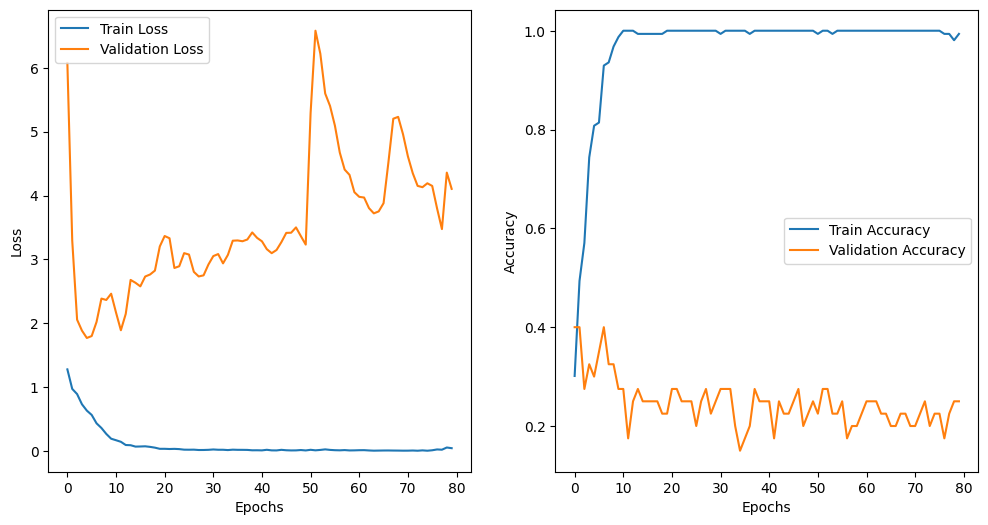

2/2 [==============================] - 0s 8ms/step - loss: 4.1040 - accuracy: 0.2500
Model Accuracy: 0.2500 (Filter Size: 5, Num Filters: 32, Stride: (2, 2), Pool Size: (2, 2))
Fields in the first vector of X_train:
X_train_map shape: (156, 576, 640)
X_train_momentum shape: (156,)
X_train_refractive_index shape: (156,)
X_train_ckov shape: (156,)
X_train_mip_position shape: (156, 2)
First element of y_train: [0 1 0]
Epoch 1/10
10/10 [==============================] - 5s 51ms/step - loss: 0.0456 - accuracy: 0.9936 - val_loss: 3.8119 - val_accuracy: 0.2750
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0265 - accuracy: 1.0000 - val_loss: 3.5888 - val_accuracy: 0.2750
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0405 - accuracy: 0.9936 - val_loss: 3.4352 - val_accuracy: 0.3000
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 0.0340 - accuracy: 1.0000 - val_loss: 3.3431 - val_accuracy: 0.2750
Epoch 5/10
10/10 

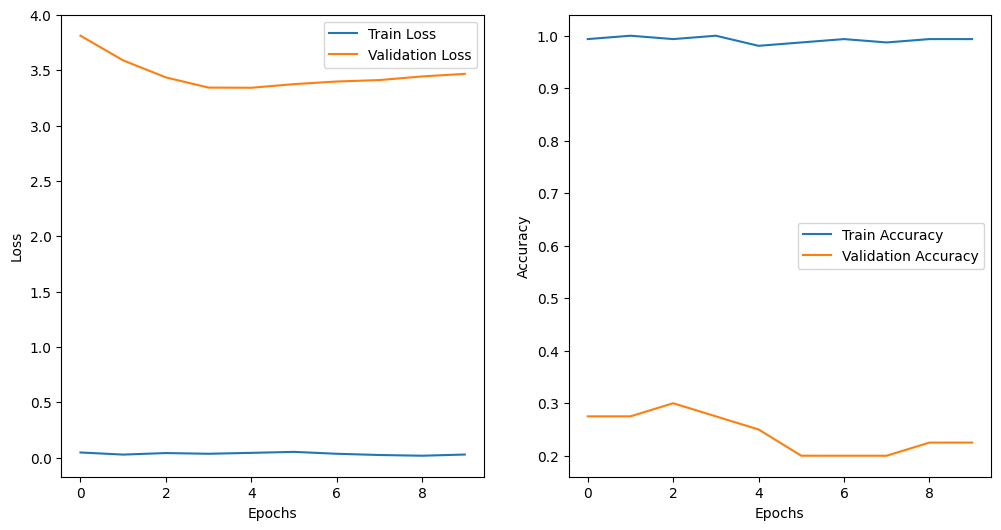

Number of particles: 488
maps shape = (488, 576, 640)
mip_position_array shape = (488, 2)
distances_map_list shape = (488,)


<ipython-input-4-b683fdcef03f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(f"distances_map_list shape = {np.array(distances_map_list).shape}")


 in  def train(self, filename) : X_train_dist2mip shape : (390, 190)
maps shape = (488, 576, 640)
mip_position_array shape = (488, 2)
distances_map_list shape = (488,)


<ipython-input-4-b683fdcef03f>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(f"distances_map_list shape = {np.array(distances_map_list).shape}")


Epoch 1/80
13/13 [==============================] - 4s 38ms/step - loss: 1.2260 - accuracy: 0.3385 - val_loss: 2.3129 - val_accuracy: 0.4286
Epoch 2/80
13/13 [==============================] - 0s 10ms/step - loss: 1.0490 - accuracy: 0.4923 - val_loss: 1.6947 - val_accuracy: 0.4184
Epoch 3/80
13/13 [==============================] - 0s 10ms/step - loss: 0.9979 - accuracy: 0.4821 - val_loss: 1.4502 - val_accuracy: 0.4286
Epoch 4/80
13/13 [==============================] - 0s 9ms/step - loss: 0.9504 - accuracy: 0.5410 - val_loss: 1.3695 - val_accuracy: 0.4286
Epoch 5/80
13/13 [==============================] - 0s 9ms/step - loss: 0.9042 - accuracy: 0.5949 - val_loss: 1.2993 - val_accuracy: 0.3980
Epoch 6/80
13/13 [==============================] - 0s 10ms/step - loss: 0.8214 - accuracy: 0.6436 - val_loss: 1.2755 - val_accuracy: 0.3878
Epoch 7/80
13/13 [==============================] - 0s 10ms/step - loss: 0.7906 - accuracy: 0.6564 - val_loss: 1.2414 - val_accuracy: 0.4082
Epoch 8/80
13/1

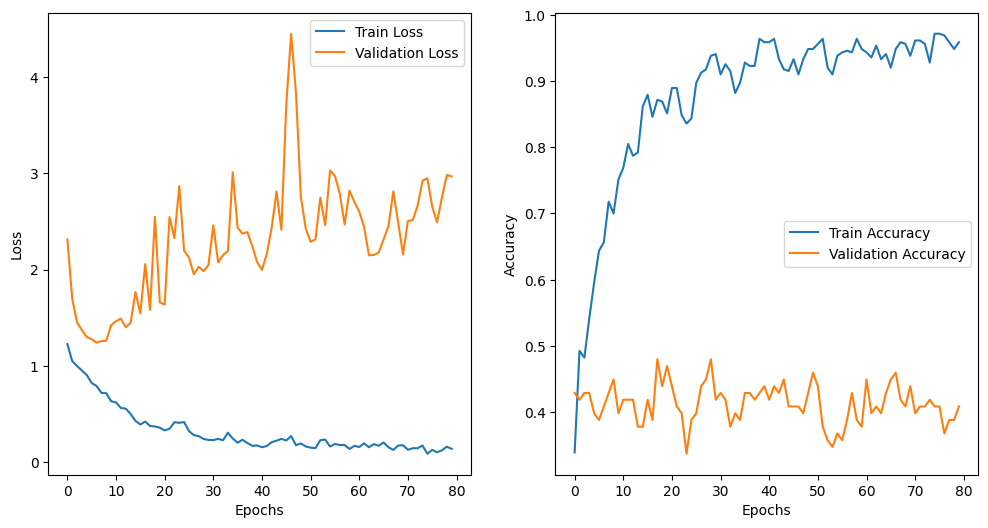

4/4 [==============================] - 0s 4ms/step - loss: 2.9665 - accuracy: 0.4082
Model Accuracy: 0.4082 (Filter Size: 5, Num Filters: 32, Stride: (2, 2), Pool Size: (2, 2))
Fields in the first vector of X_train:
X_train_map shape: (390, 576, 640)
X_train_momentum shape: (390,)
X_train_refractive_index shape: (390,)
X_train_ckov shape: (390,)
X_train_mip_position shape: (390, 2)
First element of y_train: [0 0 1]
Epoch 1/10
25/25 [==============================] - 5s 25ms/step - loss: 0.1873 - accuracy: 0.9282 - val_loss: 2.7571 - val_accuracy: 0.3980
Epoch 2/10
25/25 [==============================] - 0s 13ms/step - loss: 0.1867 - accuracy: 0.9256 - val_loss: 2.6498 - val_accuracy: 0.3980
Epoch 3/10
25/25 [==============================] - 0s 15ms/step - loss: 0.1815 - accuracy: 0.9308 - val_loss: 2.5973 - val_accuracy: 0.3878
Epoch 4/10
25/25 [==============================] - 0s 11ms/step - loss: 0.1710 - accuracy: 0.9359 - val_loss: 2.5755 - val_accuracy: 0.3980
Epoch 5/10
25/25 

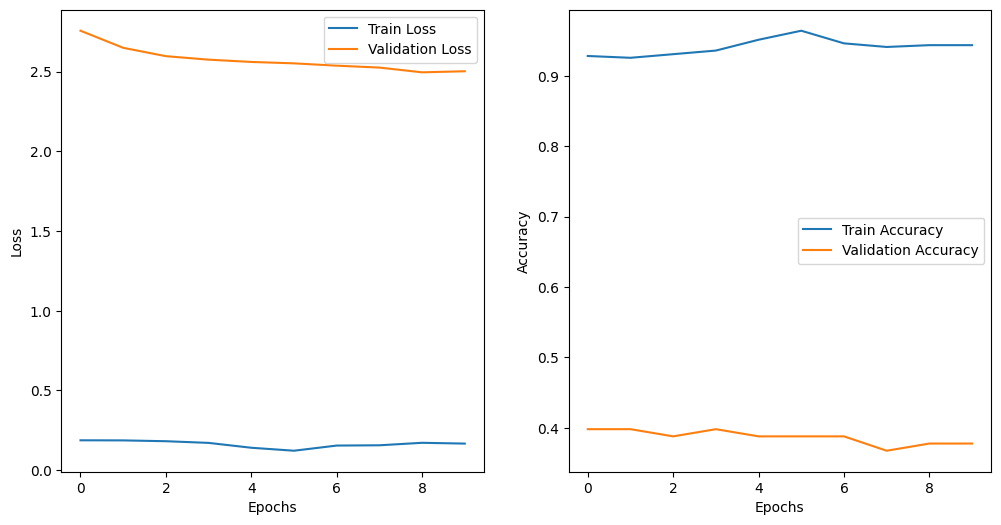

In [12]:
#resolution = 4

print_vals = False
from numpy.linalg import norm
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.preprocessing.sequence import pad_sequences


from __future__ import print_function
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, Lambda, Flatten, Dense, concatenate, BatchNormalization, MaxPooling2D, Dropout, LeakyReLU, Masking
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

class Constants:
    PION_MASS = 0.1396
    KAON_MASS = 0.4937
    PROTON_MASS = 0.938

np.set_printoptions(precision=4)

@staticmethod
def calculate_mass(momentum, refractiveIndex, ckov):
    """ args : momentum, refractiveIndex, ckov
        returns : mass
    """
    mass = momentum * np.sqrt((refractiveIndex * np.cos(ckov))**2 - 1)
    return mass


class ParticleDataUtils:
  
    class ParticleInfo:
        def __init__(self, momentum, mass, refractiveIndex, ckov, filledBins, mip_position, radiuses):

            self.momentum = momentum
            self.mass = mass
            self.refractiveIndex = refractiveIndex
            self.ckov = ckov
            self.filledBins = filledBins
            self.mip_position = mip_position
            self.mass_category = self.infer_mass_category_from_ckov(momentum, refractiveIndex, ckov)  # Infer mass category based on mass
            self.distances_to_mip = self.calculate_distances_to_mip()  # Calculate distances
            self.radiuses = radiuses

        @staticmethod
        def infer_mass_category_from_ckov(momentum, refractiveIndex, ckov):
            mass = momentum * np.sqrt((refractiveIndex * np.cos(ckov))**2 - 1)
            
            mass_category = "unknown"
            if abs(mass - Constants.PION_MASS) < 1e-4:
                mass_category = "pion"
            elif abs(mass - Constants.KAON_MASS) < 1e-4:
                mass_category = "kaon"
            elif abs(mass - Constants.PROTON_MASS) < 1e-4:
                mass_category = "proton"
            if print_vals:
              print(f"\ninfer_mass_category_from_ckov :  momentum = {momentum}|  mass_calc = {mass} |  mass_category={mass_category} | refractiveIndex = {refractiveIndex} | ckov = {ckov}")
            return mass_category

        @staticmethod
        def infer_mass_category(mass):
            if abs(mass - Constants.PION_MASS) < 1e-6:
                return "pion"
            elif abs(mass - Constants.KAON_MASS) < 1e-6:
                return "kaon"
            elif abs(mass - Constants.PROTON_MASS) < 1e-6:
                return "proton"
            else:
                return "unknown"

        def __str__(self):
            if print_vals:
              return (f"ParticleInfo(momentum={self.momentum} | mass={self.mass} |  mass_category={self.mass_category} | "
                      f"refractiveIndex={self.refractiveIndex} | ckov={self.ckov} | num_filled_bins={len(self.filledBins)}, "
                      f"mip_position={self.mip_position})")

        def calculate_distances_to_mip(self):
            """Calculate Euclidean distances from all filled bins to MIP position"""
            distances = [norm(np.array(pos) - self.mip_position) for pos in self.filledBins]
            return distances


    def __init__(self, filename = "default_filename.h5", percentage_to_read = 100):
        self.filename = filename
        self.percentage_to_read = percentage_to_read
        self.particle_vector = self.load_data(filename)
        self.particle_info = self.process_data(self.particle_vector, self.percentage_to_read)
        self.num_particles = len(self.particle_info)
        self.momentum_scaler, self.momentum_stats = self.create_scaler("momentum")
        self.refractive_index_scaler, self.refractive_index_stats = self.create_scaler("refractiveIndex")
        self.ckov_scaler, self.ckov_stats = self.create_scaler("ckov")
        self.distances_scaler, self.distances_stats = self.create_scaler("distances")


    def load_data(self, filename):
        drive_path = '/content/drive/MyDrive/Colab Notebooks/CERN_ML/CNN_PID/'  # Update the path to your Google Drive folder
        file_path = os.path.join(drive_path, filename)
        particle_vector = []
        with h5py.File(file_path, 'r') as file:
            #file.visititems(print_hdf5_items)
            for i, group_name in enumerate(file):
                group = file[group_name]

                # Read scalar values
                momentum = group.attrs['Momentum']
                mass = group.attrs['Mass']
                refractiveIndex = group.attrs['RefractiveIndex']
                ckov = group.attrs['Ckov']
                mip_position = group['MipPos']
                mip_position = mip_position[...]  # Retrieve the data as a numpy array

                mip_position = mip_position.tolist()  # Convert the numpy array to a list

                # Read filledBins
                filled_bins_dataset = group['FilledBins']
                filled_bins_data = filled_bins_dataset[...]  # Retrieve the data as a numpy array

                filled_bins = filled_bins_data.tolist()  # Convert the numpy array to a list

                # get window : 
                calculator = CkovCalculator()
                results = calculator.calcCkovFromMass(momentum, refractive_index)
                radiuses = []
                for particle, radius in results.items():
                    #print(f"{particle} Radius: {radius}")
                    radiuses.append(radius)

                # the biggest radius should then extract a window around the MIP 

                # Find the particle with the biggest radius
                #max_radius_particle = max(radiuses, key=radiuses.get)
                #max_radius = radiuses[max_radius_particle]
                max_radius = radiuses[2]

                # Extract a window around the MIP using the biggest radius
                #window_size = int(max_radius * 2)  # Adjust the size as needed      
                # NB!!! add resolution here? Or multiply elswhere..

                particle_info = ParticleDataUtils.ParticleInfo(
                    momentum, mass, refractiveIndex, ckov, filledBins=filled_bins, mip_position=mip_position, radiuses = radiuses)
                if print_vals == True:
                  print(particle_info)  # This will use the __str__() method of ParticleInfo

                particle_vector.append(particle_info)

        return particle_vector

    def process_data(self, particle_vector, percentage):

        # Calculate the number of particles based on the percentage
        num_particles = int(len(particle_vector) * (percentage / 100.0))

        # Slice the particle_vector to the desired percentage
        particle_vector = particle_vector[:num_particles]
        return particle_vector


    def create_scaler(self, feature):
        if feature == "momentum":
            values = np.array([info.momentum for info in self.particle_info]).reshape(-1, 1)
        elif feature == "refractiveIndex":
            values = np.array([info.refractiveIndex for info in self.particle_info]).reshape(-1, 1)
        elif feature == "ckov":
            values = np.array([info.ckov for info in self.particle_info]).reshape(-1, 1)
        elif feature == "distances":
            distances = []
            for info in self.particle_info:
                distances.extend(info.distances_to_mip)
            values = np.array(distances).reshape(-1, 1)
        else:
            raise ValueError(f"Invalid feature: {feature}")

        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(values)
        stats = {
            "mean": scaler.mean_[0],
            "std": scaler.scale_[0]
        }
        return scaler, stats



# create a map, the resolution is the "inverse" 
def create_map(filledBins=None, resolution=4):
    map_shape = (int(144 * resolution), int(160 * resolution))
    map_data = np.zeros(map_shape)
    
    if filledBins is not None:
        for bins in filledBins:
            x, y = bins
            x_index = int(x * resolution)
            y_index = int(y * resolution)
            map_data[y_index, x_index] = 1

    return map_data

class MassClassifier:
    def __init__(self, percentage_to_read = 10, resolution = 4):
        self.model = None
        self.utils = None
        self.percentage_to_read = percentage_to_read
        self.resolution = resolution


    def load_data(self, filename):
        self.utils = ParticleDataUtils(filename, percentage_to_read = self.percentage_to_read) # specify percentage of particles to read..
        print(f"Number of particles: {self.utils.num_particles}")

    def preprocess_data(self):
        particle_info = self.utils.particle_info


        # Prepare the inputs
        
        # create a map with resolution to be chosen, iterate over teh filledBins vector
        X_map = np.array([create_map(filledBins = info.filledBins, resolution = self.resolution) for info in particle_info])
        filled_bins_array = np.array([info.filledBins for info in particle_info], dtype=object)



        X_momentum = np.array([info.momentum for info in particle_info])#.reshape(-1, 32, 32, 1)
        X_refractive_index = np.array([info.refractiveIndex for info in particle_info])#.reshape(-1, 32, 32, 1)
        X_ckov = np.array([info.ckov for info in particle_info])#.reshape(-1, 32, 32, 1)
        X_mip_position = np.array([info.mip_position for info in particle_info])

        # calculate radiuses (radius of f(m_i) where m_i = [m_pion, m_kaon, m_proton],  and n, p, + later {xRad, yRad, theta, phi} fixed for a given track) 
        # for mass-hypothesis

        #alc_dist2mip(maps = None,  mip_positions = None, resolution = 10):
        
        
        
        # change shape to be num_samples, pad_sequences, 3:
        X_dist2mip = calc_dist2mip(maps = X_map, mip_positions = X_mip_position, resolution = self.resolution)

        X_dist2mip = pad_sequences(X_dist2mip, padding='post')

        # extracting the window around the MIP:

        #  extract_segment_around_mip(mip_positions = None, radiuses = None, maps = None, std = 7):
        #X_windows = extract_segment_around_mip(mip_positions = X_mip_position, radiuses = X_radiuses, maps = X_map, std = 7)
        
        # this adds wrong? denne dimensionen er en for stor allerede?
        #X_windows = np.expand_dims(X_windows, -1) 
        #print(f"X_windows shape = {np.array(X_windows).shape}")
        # X_windows will have various size (X_window_sizes + pad) x (X_window_sizes + pad) 


        # check the impact of resolution:
        #print_points(filled_bins_array = filled_bins_array, map_array = X_map, mip_position_array= X_mip_position, resolution = resolution)

        # plot the points and the MIP
        #plot_maps(filled_bins_array =filled_bins_array, map_array = X_map, mip_position_array= X_mip_position, X_momentum = X_momentum, X_refractive_index= X_refractive_index, X_ckov = X_ckov, percentage_to_plot=5, resolution = resolution)


        # Normalize the inputs NB commented out scaling !!!
        #X_momentum = self.utils.momentum_scaler.transform(X_momentum.reshape(-1, 1))#.reshape(-1, 32, 32, 1)
        #X_refractive_index = self.utils.refractive_index_scaler.transform(X_refractive_index.reshape(-1, 1))#.reshape(-1, 32, 32, 1)
        #X_ckov = self.utils.ckov_scaler.transform(X_ckov.reshape(-1, 1))#.reshape(-1, 32, 32, 1)

        #X_mip_position[0,:] = self.utils.distances_scaler.transform(X_mip_position[0,:])
        #X_mip_position[1,:] = self.utils.distances_scaler.transform(X_mip_position[1,:])



        # Prepare the outputs
        y = np.array([info.mass_category for info in particle_info])

        # Convert the outputs to one-hot encoded vectors
        lb = LabelBinarizer()
        y = lb.fit_transform(y)

        # Split the data into train and test sets

        X_train_dist2mip, X_test_dist2mip, X_train_map, X_test_map, X_train_momentum, X_test_momentum, X_train_refractive_index, X_test_refractive_index, \
            X_train_ckov, X_test_ckov, X_train_mip_position, X_test_mip_position, y_train, y_test = \
            train_test_split(X_dist2mip, X_map, X_momentum, X_refractive_index, X_ckov, X_mip_position, y, test_size=0.2, random_state=42)

        X_train = {"X_train_map": X_train_map, "X_train_momentum": X_train_momentum, "X_train_refractive_index": X_train_refractive_index,
                   "X_train_ckov": X_train_ckov, "X_train_mip_position": X_train_mip_position, "X_train_dist2mip": X_train_dist2mip}

        X_test = {"X_test_map": X_test_map, "X_test_momentum": X_test_momentum, "X_test_refractive_index": X_test_refractive_index,
                  "X_test_ckov": X_test_ckov, "X_test_mip_position": X_test_mip_position, "X_test_dist2mip": X_test_dist2mip}

        return (X_train, X_test, y_train, y_test)

    def build_model(self, input_sequence_length = None):

        #map_shape = (None, None, 1)  # Variable shape for the map input

        momentum_shape = (1,)
        refractive_index_shape = (1,)
        mip_position_shape = (2,)

        # Grid search parameters
        # Grid search parameters
        filter_sizes = [5]  # Filter sizes to test
        num_filters = [32]#[16, 32]  # Number of filters to test
        strides = [(2, 2)]#[(1, 1), (2, 2)]  # Strides to test
        pool_sizes = [(2, 2)]  # Max pooling sizes to test
        fc1_units = [64]#, 128]  # Number of units in fc1 to test
        fc2_units = [16]#, 32]  # Number of units in fc2 to test

        best_accuracy = 0
        best_model = None

        for filter_size in filter_sizes:
            for num_filter in num_filters:
                for stride in strides:
                    for pool_size in pool_sizes:
                        for fc1_unit in fc1_units:
                            for fc2_unit in fc2_units:
                              # Create a new model configuration

                              # X_dist2mip



                              #dist2mip_input = Input(shape=dist2mip_shape, name="dist2mip_input")
                              momentum_input = Input(shape=momentum_shape, name="momentum_input")
                              refractive_index_input = Input(shape=refractive_index_shape, name="refractive_index_input")
                              mip_position_input = Input(shape=mip_position_shape, name="mip_position_input")



                              # Distance to MIP:
                              dist2mip_input = Input(shape=(input_sequence_length,), name="dist2mip_input")

                              # to ignore the padded values:
                              dist2mip_masked = Masking(mask_value=0.)(dist2mip_input)

                              dense_dist2mip_1 = Dense(32, name="dense_dist2mip_1")(dist2mip_masked)
                              bn_dist2mip_1 = BatchNormalization(name="bn_dist2mip_1")(dense_dist2mip_1)
                              relu_dist2mip_1 = Activation('relu', name="relu_dist2mip_1")(bn_dist2mip_1)
                              dropout_dist2mip_1 = Dropout(0.2, name="dropout_dist2mip_1")(relu_dist2mip_1)

                              #dense_dist2mip_2 = Dense(64, name="dense_dist2mip_2")(dropout_dist2mip_1)
                              #bn_dist2mip_2 = BatchNormalization(name="bn_dist2mip_2")(dense_dist2mip_2)
                              #relu_dist2mip_2 = Activation('relu', name="relu_dist2mip_2")(bn_dist2mip_2)
                              #rel_dist2mip = Dropout(0.2, name="dropout_dist2mip_2")(relu_dist2mip_2)

                              # NB! now skipping the BatchNormalization
                              # Refractive index Input
                              dense_ref_index = Dense(16, name="dense_ref_index")(refractive_index_input)
                              bn_ref_index = BatchNormalization(name="bn_ref_index")(dense_ref_index)
                              relu_ref_index = Activation('relu', name="relu_ref_index")(dense_ref_index)
                              dropout_ref_index = Dropout(0.2, name="dropout_ref_index")(relu_ref_index)

                              # Momentum Input
                              dense_momentum = Dense(16, name="dense_momentum")(momentum_input)
                              bn_momentum = BatchNormalization(name="bn_momentum")(dense_momentum)
                              relu_momentum = Activation('relu', name="relu_momentum")(dense_momentum)
                              dropout_momentum = Dropout(0.2, name="dropout_momentum")(relu_momentum)

                              # MIP Position Input
                              dense_mip_pos = Dense(16, name="dense_mip_pos")(mip_position_input)
                              bn_mip_pos = BatchNormalization(name="bn_mip_pos")(dense_mip_pos)
                              relu_mip_pos = Activation('relu', name="relu_mip_pos")(dense_mip_pos)
                              dropout_mip_pos = Dropout(0.2, name="dropout_mip_pos")(relu_mip_pos)



                              # Concatenation
                              concat = concatenate([dropout_dist2mip_1, dropout_ref_index, dropout_momentum, dropout_mip_pos])

                              output = Dense(3, activation='softmax')(concat) # NB LEGG MERKE TIL AT DENNE ER ENDRET FRA FC2

                              model = Model(inputs=[dist2mip_input, momentum_input, refractive_index_input, mip_position_input],
                                            outputs=output)

                              #model = Model(inputs=[window_input], outputs=[output])
                              model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), # NB changed from 0.0002
                                            loss="categorical_crossentropy", metrics=["accuracy"])

                              X_train, X_test, y_train, y_test = self.preprocess_data()

                              # Train the model
                              history = model.fit(
                                  x=[X_train["X_train_dist2mip"], X_train["X_train_momentum"], X_train["X_train_refractive_index"],
                                      X_train["X_train_mip_position"]], # x=[X_train_dist2mip, X_train_momentum, X_train_refractive_index, X_train_ckov, X_train_mip_position]
                                  y=y_train,
                                  validation_data=(
                                      [X_test["X_test_dist2mip"], X_test["X_test_momentum"], X_test["X_test_refractive_index"],
                                        X_test["X_test_mip_position"]],
                                      y_test
                                  ),
                                  batch_size=32,
                                  epochs=80,
                                  verbose=1
                              )

                              # plotting the worst cases?:
                              #y_pred_test = model.predict([X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_mip_position"]])
                              #plot_worst(model, y_test, X_test_map, X_test_momentum, X_test_refractive_index, X_test_ckov, X_test_mip_position, y_pred):
                              print("Shape of y_test: ", y_test.shape)
                              print("Shape of X_test_map: ", X_test["X_test_map"].shape)
                             # print("Shape of X_test_windows: ", X_test["X_test_windows"].shape)
                              print("Shape of X_test_momentum: ", X_test["X_test_momentum"].shape)
                              print("Shape of X_test_refractive_index: ", X_test["X_test_refractive_index"].shape)
                              print("Shape of X_test_ckov: ", X_test["X_test_ckov"].shape)
                              print("Shape of X_test_mip_position: ", X_test["X_test_mip_position"].shape)
                              #print("Shape of y_pred_test: ", y_pred_test.shape)
                              try: # NB! commented out this line
                                #plot_worst_(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], y_pred_test)
                                plot_worst_(model, y_test, X_test["X_test_map"], X_test["X_test_momentum"], X_test["X_test_refractive_index"], X_test["X_test_ckov"], X_test["X_test_mip_position"], self.resolution)
                              except Exception as e:
                                print(f"skip plot_worst_ due to error: {e}")
                              self.plot_training_history(history)

                              # Evaluate the model
                              _, accuracy = model.evaluate(
                                  x=[X_test["X_test_dist2mip"], X_test["X_test_momentum"], X_test["X_test_refractive_index"],
                                        X_test["X_test_mip_position"]],
                                  y=y_test,
                                  verbose=1
                              )

                              print(f"Model Accuracy: {accuracy:.4f} (Filter Size: {filter_size}, Num Filters: {num_filter}, "
                                    f"Stride: {stride}, Pool Size: {pool_size})")

                              # Check if the current model configuration is better
                              if accuracy > best_accuracy:
                                  best_accuracy = accuracy
                                  best_model = model

        # Set the best model as the final model
        self.model = best_model


    def train_model(self, X_train, X_test, y_train, y_test):
        # Compile the model


        X_train_map = X_train["X_train_map"]
        X_train_dist2mip = X_train["X_train_dist2mip"]
        X_train_momentum = X_train["X_train_momentum"]
        X_train_refractive_index = X_train["X_train_refractive_index"]
        X_train_ckov = X_train["X_train_ckov"]
        X_train_mip_position = X_train["X_train_mip_position"]

        X_test_map = X_test["X_test_map"]
        X_test_dist2mip = X_test["X_test_dist2mip"]
        X_test_momentum = X_test["X_test_momentum"]
        X_test_refractive_index = X_test["X_test_refractive_index"]
        X_test_ckov = X_test["X_test_ckov"]
        X_test_mip_position = X_test["X_test_mip_position"]
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss="categorical_crossentropy", metrics=["accuracy"])

        # Print fields in the first vector of X_train
        print("Fields in the first vector of X_train:")
        print("X_train_map shape:", X_train_map.shape)
        print("X_train_momentum shape:", X_train_momentum.shape)
        print("X_train_refractive_index shape:", X_train_refractive_index.shape)
        print("X_train_ckov shape:", X_train_ckov.shape)
        print("X_train_mip_position shape:", X_train_mip_position.shape)

        # Print the first element of y_train
        print("First element of y_train:", y_train[0])

        # Train the model
        history = self.model.fit(
            x=[X_train_dist2mip, X_train_momentum, X_train_refractive_index, X_train_mip_position],
            y=y_train,
            validation_data=(
                [X_test_dist2mip,  X_test_momentum, X_test_refractive_index, X_test_mip_position],
                y_test
            ),
            batch_size=16,
            epochs=10,
            verbose=1
        )
        return history

    def evaluate_model(self, X_test, y_test):
        X_test_dist2mip = X_test["X_test_dist2mip"]
        X_test_momentum = X_test["X_test_momentum"]
        X_test_refractive_index = X_test["X_test_refractive_index"]
        X_test_ckov = X_test["X_test_ckov"]
        X_test_mip_position = X_test["X_test_mip_position"]
        loss, accuracy = self.model.evaluate(
            x=[X_test_dist2mip, X_test_momentum, X_test_refractive_index, X_test_mip_position],
            y=y_test,
            verbose=0
        )
        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")



    def plot_training_history(self, history):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history["loss"], label="Train Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history["accuracy"], label="Train Accuracy")
        plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.show()

    def train(self, filename):
        self.load_data(filename)
        X_train, X_test, y_train, y_test = self.preprocess_data()
        X_train_dist2mip = np.array(X_train["X_train_dist2mip"])



        print(f" in  def train(self, filename) : X_train_dist2mip shape : {X_train_dist2mip.shape}")
        #X_train_dist2mip = X_train_dist2mip.reshape(X_train_dist2mip.shape[0], X_train_dist2mip.shape[1],, 1)
        #for dist in X_train_dist2mip:
        #  print(f"dist = {dist}")

        input_sequence_length = len(max(X_train_dist2mip, key=len))

        self.build_model(input_sequence_length = input_sequence_length)

        history = self.train_model(X_train, X_test, y_train, y_test)
        self.evaluate_model(X_test, y_test)
        self.plot_training_history(history)



    def plot_worst(model, y_test, X_test_map, X_test_momentum, X_test_refractive_index, X_test_ckov, X_test_mip_position, y_pred):
      # 1. Predict labels on validation data

      # 2. Calculate the difference between predicted and actual labels
      losses = tf.keras.losses.categorical_crossentropy(y_test, y_pred).numpy()

      # Sort the indices of the losses from highest to lowest
      sorted_indices = np.argsort(losses)[::-1]

      # Get the indices of the worst performing 10%
      worst_10_percent_indices = sorted_indices[:int(0.1*len(sorted_indices))]

      # Create figure and axes
      num_plots = len(worst_10_percent_indices)
      #fig, axes = plt.subplots(num_plots, 1, figsize=(8, 20))
      fig, axes = plt.subplots(num_plots,figsize=(8, 20))

      # Define mass categories
      mass_categories = ["pion", "kaon", "proton"]

      # 3. Create plots for these cases, including their feature information and predicted vs actual labels
      for i, index in enumerate(worst_10_percent_indices):
          # Get the map and corresponding information
          map_data = X_test_map[index, :, :]
          actual_mass_category = mass_categories[np.argmax(y_test[index])]

          print(f"y_test[index] = {y_test[index]}")

          predicted_mass_category = mass_categories[np.argmax(y_pred[index])]
          ckov = X_test_ckov[index]
          mip_position = X_test_mip_position[index]
          momentum = X_test_momentum[index]
          refractive_index = X_test_refractive_index[index]
          
          mass_actual = momentum * np.sqrt(refractive_index**2 * np.cos(ckov)*np.cos(ckov) - 1)
          
          # Check if the value is NaN (invalid Cherenkov angle)
          if np.isnan(mass_actual):
              mass_actual = "Invalid"

          # Plot the map
          axes[i].imshow(map_data, cmap='gray')

          # Add a red dot at the MIP position
          axes[i].plot(mip_position[0], mip_position[1], 'ro')

          # Set the title with the information
          axes[i].set_title(f"Actual Mass")#: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]} \nCKOV: {ckov}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")
          #
          axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\nMass: {mass_actual}, Mass_prob = {y_pred[index]} \nCKOV: {ckov}, MIP Position: {mip_position}, \nMomentum: {momentum}, Refractive Index: {refractive_index}")

          #axes[i].set_title(f"Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category}, Mass: {mass_actual}\nCKOV: {ckov}, MIP Position: {mip_position}, Momentum: {momentum}, Refractive Index: {refractive_index}")
          axes[i].axis('off')

          print("\n")
          print(f"  Actual Mass: {actual_mass_category}, Predicted Mass: {predicted_mass_category},\n Mass: {mass_actual}, Mass_prob = {y_pred[index]} \n CKOV: {ckov}, MIP Position: {mip_position}, \n  Momentum: {momentum}, Refractive Index: {refractive_index}")
      # Adjust the spacing between subplots
      plt.tight_layout()

      # Show the plot
      plt.show()


# Usage example

# 3 percent occupancy:
classifier = MassClassifier(percentage_to_read = 2, resolution = 4) # pass percentage of dataset to read 
classifier.train("ParticleInfo.h5")


# only 1 percent occupancy :
classifier2 = MassClassifier(percentage_to_read = 5, resolution = 4) # pass percentage of dataset to read 
classifier2.train("ParticleInfo_1percent.h5")



In [13]:
X_train_dist2mip_padded = pad_sequences(X_train_dist2mip, maxlen=input_sequence_length, padding='post', value=0.0)


NameError: ignored

In [ ]:
# Plot training loss and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation data


y_train_pred = model.predict([X_train_map, X_train_momentum, X_train_refractive_index, X_train_mip_position])

# Convert the predictions from categorical back to original labels
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Calculate the confusion matrix
#cm = confusion_matrix(y_train, y_train_pred_classes)

# Calculate the confusion matrix
rounded_labels=np.argmax(y_train, axis=1)

cm = confusion_matrix(rounded_labels, y_train_pred_classes)

# Use seaborn to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix Training Data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation data
y_val_pred = model.predict([X_test_map, X_test_momentum, X_test_refractive_index, X_test_mip_position])

# Convert the predictions from categorical back to original labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Calculate the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)

cm = confusion_matrix(rounded_labels, y_val_pred_classes)

# Use seaborn to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix Validation Data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
